In [17]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import helpers
import time

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, Normalizer, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_distances


from sklearn import metrics
from sklearn.cluster import KMeans

from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [18]:
load_dir = '/home/charles/Documents/code/Tensorflow/Data/ChannelizedMedia'

In [19]:
filename = '/OptSnapshots.pkl.gz'
with gzip.open(load_dir+filename) as fp:
    data = pickle.load(fp)

if filename == '/OptSnapshots.pkl.gz':
    data = data[:,:2025]

n = data.shape[0]
d2 = data.shape[1]
d = int(np.sqrt(d2))
images = np.reshape(data,[n,d,d])

data_images = images

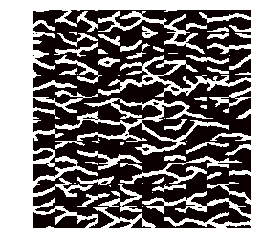

In [4]:
nshow = 10
nshow2 = nshow**2 
im_array = images[:nshow2,:,:]
Block = np.bmat([ [im_array[i+nshow*j] for i in range(nshow)] for j in range(nshow)])
Block.shape
img = plt.imshow(Block)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('OptSnapshots_32.png',dpi=100, bbox_inches='tight')
plt.show()

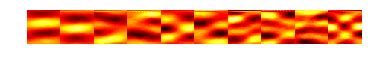

Noise Variance:  49910755.2985


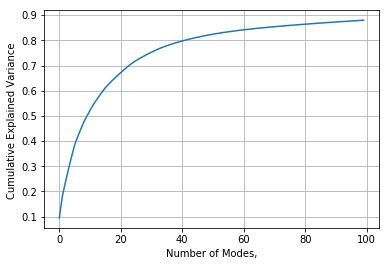

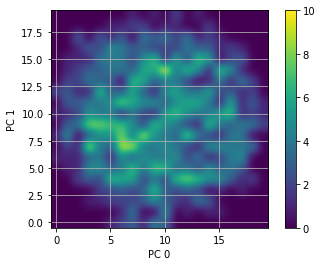

best bandwidth: 10.0


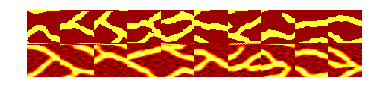

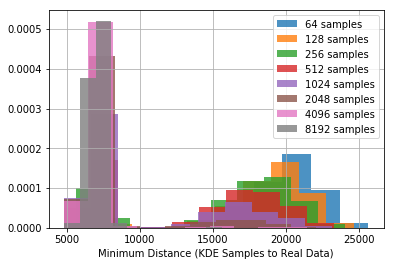

Mean Reconstruction Error:  2.3728509963e-12


In [5]:
# center = scale(X, axis=0, with_mean=True, with_std=False, copy=True)
# data = np.random.randn(20, 40)
# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=5))])
# pipeline.fit_transform(data)

nmodes=100
pca = PCA(n_components = nmodes, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
data_pca = pca.fit_transform( data )
data_recon = pca.inverse_transform(data_pca)

nshow = 10
nshow2 = nshow**2 
images = np.reshape(pca.components_,[nmodes,d,d])
im_array = images[:nshow2,:,:]
Block = np.bmat( [im_array[i] for i in range(nshow)] )
img = plt.imshow(Block)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('OptSnapshots_32_Modes.png',dpi=100, bbox_inches='tight')
plt.show()

print("Noise Variance: " , pca.noise_variance_)

plt.plot(np.cumsum(pca.explained_variance_) / (pca.noise_variance_ + np.sum(pca.explained_variance_) ))
plt.xlabel('Number of Modes,')
plt.ylabel('Cumulative Explained Variance ')
plt.grid()
plt.savefig('OptSnapshots_32_CEV.png',dpi=100, bbox_inches='tight')
plt.show()

pcidx1=0
pcidx2=1
nbins = 20

x = data_pca[:,pcidx1]#/pca.explained_variance_[0]
y = data_pca[:,pcidx2]#/pca.explained_variance_[1]
h, x, y, p = plt.hist2d(x, y, bins = nbins)
plt.clf()
plt.imshow(h, origin = "lower", interpolation = "gaussian")
# plt.plot(x,y,'.')
plt.xlabel('PC '+str(pcidx1))
plt.ylabel('PC '+str(pcidx2))
plt.grid()
plt.colorbar()
plt.savefig("test.pdf",dpi=100, bbox_inches='tight')
plt.show()


from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit( data_pca[:,:nmodes] )
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_
# sample points from the data
nsamples_kde = 10
new_data = kde.sample( nsamples_kde, random_state=0)
new_data = pca.inverse_transform(new_data)
# grid data
new_data = new_data.reshape((1, nsamples_kde, -1))
real_data = data[:nsamples_kde].reshape((1, nsamples_kde, -1))
Block1 = np.bmat( [ np.reshape(real_data[0,i,:],[d,d]) for i in range(nsamples_kde)] )
Block2 = np.bmat( [ np.reshape(new_data[0,i,:],[d,d]) for i in range(nsamples_kde)] )
Block = np.vstack((Block1,Block2))
img = plt.imshow(Block)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('OptSnapshots_32_KDESamples'+str(nmodes)+'.png',dpi=100, bbox_inches='tight')
plt.show()




plt.figure()
for nsamples_kde in 2**np.arange(6,14,1): #[100,1000]:#,10000]:
    new_data = kde.sample( nsamples_kde, random_state=0); new_data = pca.inverse_transform(new_data)
    pwd = pairwise_distances(X=new_data, Y=data, metric='euclidean')
#     plt.plot(pwd.min(axis=0),'.',alpha=0.5,ms=2)
    plt.hist(pwd.min(axis=0),alpha=0.8,bins=10,normed=True, label=str(nsamples_kde)+' samples')
    plt.legend()
plt.grid()
plt.xlabel('Minimum Distance (KDE Samples to Real Data)')
plt.savefig('OptSnapshots_32_KDESamplesPWD'+str(nmodes)+'.png',dpi=100, bbox_inches='tight')
plt.show()
print("Mean Reconstruction Error: ", np.linalg.norm( (data_recon-data).mean(axis=0),2) )

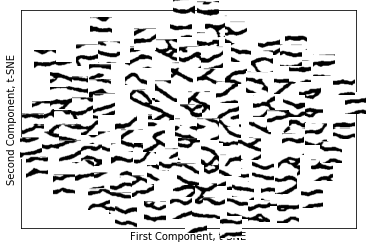

In [56]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

X = data
n_samples, n_features = X.shape
n_neighbors = 30

from scipy.misc import imresize
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imresize(data_images[i], 50, interp='bilinear', mode=None), cmap=plt.cm.gray_r),
                X[i],frameon=False)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
tsne = manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, learning_rate=1000.0, 
                     n_iter=2000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', 
                     init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.3)
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)
plt.grid()
plt.xlabel('First Component, t-SNE')
plt.ylabel('Second Component, t-SNE')
plt.savefig('OptSnapshots_32_tSNE'+str(2)+'.png',dpi=100, bbox_inches='tight')
plt.show()


tsne = manifold.TSNE(n_components=3, perplexity=30.0, early_exaggeration=4.0, learning_rate=1000.0, 
                     n_iter=2000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', 
                     init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.3)
X_tsne = tsne.fit_transform(X)

In [59]:
X_tsne.shape
X_tsne[:,[0,1]]

array([[ -4293.0458759 ,   5842.93440707],
       [  1917.43405023,   5300.32195878],
       [  1067.56154116,   2465.72203323],
       ..., 
       [  -219.54252984,  13767.47004546],
       [-13045.76334693,   -792.62837971],
       [ -7803.64378794,   3374.49239286]])

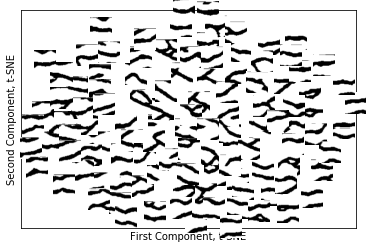

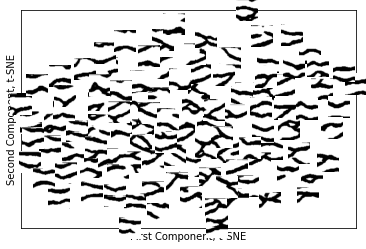

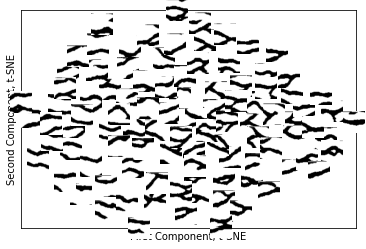

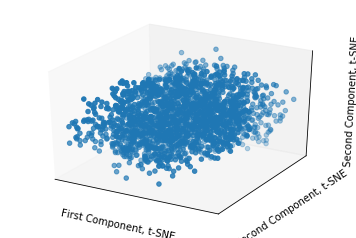

In [85]:
plot_embedding(X_tsne[:,[0,1]])
plt.grid()
plt.xlabel('First Component, t-SNE')
plt.ylabel('Second Component, t-SNE')
plt.savefig('OptSnapshots_32_tSNE'+str(3)+'_01.png',dpi=100, bbox_inches='tight')
plt.show()

plot_embedding(X_tsne[:,[0,2]])
plt.grid()
plt.xlabel('First Component, t-SNE')
plt.ylabel('Second Component, t-SNE')
plt.savefig('OptSnapshots_32_tSNE'+str(3)+'_02.png',dpi=100, bbox_inches='tight')
plt.show()

plot_embedding(X_tsne[:,[1,2]])
plt.grid()
plt.xlabel('First Component, t-SNE')
plt.ylabel('Second Component, t-SNE')
plt.savefig('OptSnapshots_32_tSNE'+str(3)+'_12.png',dpi=100, bbox_inches='tight')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:,[0,1]], X_tsne[:,[0,2]], X_tsne[:,[1,2]],'.')
plt.savefig('OptSnapshots_32_tSNE'+str(3)+'_3D.png',dpi=100, bbox_inches='tight')
plt.xticks([]), plt.yticks([]),ax.set_zticks([])
ax.set_xlabel('First Component, t-SNE')
ax.set_ylabel('Second Component, t-SNE')
ax.set_zlabel('Second Component, t-SNE')
plt.show()

In [434]:
from sklearn.cluster import DBSCAN
X = StandardScaler().fit_transform(data)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0


In [426]:
reduced_data = data_pca
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

NameError: name 'n_digits' is not defined

In [398]:
nmodes=100
pca = KernelPCA(n_components=nmodes, kernel="poly", fit_inverse_transform=True, degree=3)
data_pca = pca.fit_transform( data )
data_recon = pca.inverse_transform(data_pca)

(100, 2025)


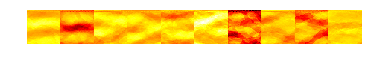

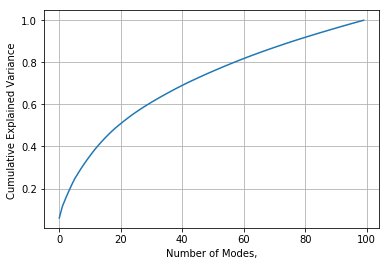

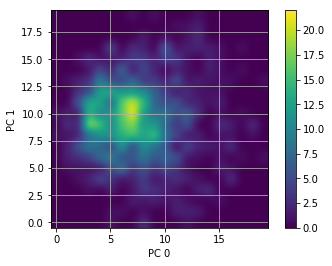

best bandwidth: 10.0


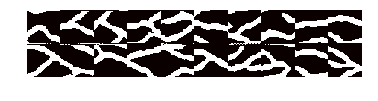

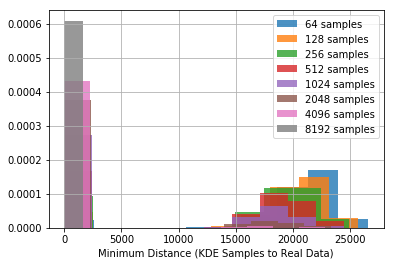

Mean Reconstruction Error:  1.5456823635e-12


In [421]:
KPCAModeCoeffs = np.identity(data_pca.shape[0])[:,:nmodes]
KPCAModes = pca.inverse_transform(KPCAModeCoeffs)[:nmodes,:]
print( KPCAModes.shape )

nshow = 10
nshow2 = nshow**2 
images = np.reshape(KPCAModes,[nmodes,d,d])
im_array = images[:nshow2,:,:]
Block = np.bmat( [im_array[i] for i in range(nshow)] )
img = plt.imshow(Block)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('OptSnapshots_32_Modes.png',dpi=100, bbox_inches='tight')
plt.show()


plt.plot(np.cumsum(pca.lambdas_) / ( np.sum(pca.lambdas_) ))
plt.xlabel('Number of Modes,')
plt.ylabel('Cumulative Explained Variance ')
plt.grid()
plt.savefig('OptSnapshots_32_CEV.png',dpi=100, bbox_inches='tight')
plt.show()

pcidx1=0
pcidx2=1
nbins = 20

x = data_pca[:,pcidx1]#/pca.explained_variance_[0]
y = data_pca[:,pcidx2]#/pca.explained_variance_[1]
h, x, y, p = plt.hist2d(x, y, bins = nbins)
plt.clf()
plt.imshow(h, origin = "lower", interpolation = "gaussian")
# plt.plot(x,y,'.')
plt.xlabel('PC '+str(pcidx1))
plt.ylabel('PC '+str(pcidx2))
plt.grid()
plt.colorbar()
plt.savefig("test.pdf",dpi=100, bbox_inches='tight')
plt.show()


from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit( data_pca[:,:nmodes] )
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_
# sample points from the data
nsamples_kde = 10
new_data = kde.sample( nsamples_kde, random_state=0)
new_data = pca.inverse_transform(new_data)
# grid data
new_data = new_data.reshape((1, nsamples_kde, -1))
real_data = data[:nsamples_kde].reshape((1, nsamples_kde, -1))
Block1 = np.bmat( [ np.reshape(real_data[0,i,:],[d,d]) for i in range(nsamples_kde)] )
Block2 = np.bmat( [ np.reshape(new_data[0,i,:],[d,d]) for i in range(nsamples_kde)] )
Block = np.vstack((Block1,Block2))
img = plt.imshow(Block)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('OptSnapshots_32_KDESamples'+str(nmodes)+'.png',dpi=100, bbox_inches='tight')
plt.show()



plt.figure()
for nsamples_kde in 2**np.arange(6,14,1): #[100,1000]:#,10000]:
    new_data = kde.sample( nsamples_kde, random_state=0); new_data = pca.inverse_transform(new_data)
    pwd = pairwise_distances(X=new_data, Y=data, metric='euclidean')
#     plt.plot(pwd.min(axis=0),'.',alpha=0.5,ms=2)
    plt.hist(pwd.min(axis=0),alpha=0.8,bins=10,normed=True, label=str(nsamples_kde)+' samples')
    plt.legend()
plt.grid()
plt.xlabel('Minimum Distance (KDE Samples to Real Data)')
plt.savefig('OptSnapshots_32_KDESamplesPWD'+str(nmodes)+'.png',dpi=100, bbox_inches='tight')
plt.show()
print("Mean Reconstruction Error: ", np.linalg.norm( (data_recon-data).mean(axis=0),2) )